<a href="https://colab.research.google.com/github/Hamakey/Kaggle_Study/blob/master/realEstatePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [334]:
import requests, bs4
import pandas as pd
from lxml import html
from urllib.parse import urlencode, quote_plus, unquote
import numpy as np

import warnings
warnings.filterwarnings('ignore')

from matplotlib import font_manager, rc
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import platform

if platform.system() == 'Windows':
    font_name = font_manager.FontPropertise(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family = font_name)
else:
    rc('font',family='AppleGothic')
    
matplotlib.rcParams['axes.unicode_minus']=False

In [98]:
#한국부동산원_아파트거래현황 조회 서비스 : 연간 지역별 아파트 거래횟수


def loadTradeCnt(startmonth,endmonth,region):
  url = 'http://openapi.reb.or.kr/OpenAPI_ToolInstallPackage/service/rest/AptTradingStateSvc/getAptTrdStateCaseOfNbr'
  ServiceKey = "HWl55GQ4cyBgljwQ9Xv3ea8ssbyiw6Dm4nouxkeDSlxhPeuwtcTIJ+KlWsWX3NtwqlPqQFpMtweXK2Y7XpOFBQ=="
  queryParams = '?' + urlencode({ quote_plus('ServiceKey') : ServiceKey, quote_plus('startmonth') : startmonth , quote_plus('endmonth') : endmonth, quote_plus('region') : region })
  request = requests.get(url + queryParams).text.encode("utf-8")
  xmlobj = bs4.BeautifulSoup(request, 'lxml-xml')
  rows = xmlobj.findAll('item')
  columns = rows[0].find_all()
  rowList = []
  nameList = []
  columnList = []
  for j in range(len(columns)):
    nameList.append(columns[j].name)
  nameList.append('tradeCnt')
  for date, cnt in map(lambda x : x.split(',') ,columns[2].text.split("|")):
    
    rowList.append([columns[0].text,columns[1].text,date,cnt])
  result = pd.DataFrame(rowList, columns = nameList)
  return result
trade_cnt_per_year = loadTradeCnt(201101,202107,11000)

In [125]:
#@title

#법정동 코드 해싱
lawd_cd = {
  '서울특별시' : [['강남구', '11680'], ['강동구', '11740'], ['강북구', '11305'], ['강서구', '11500'], ['관악구', '11620'], ['광진구', '11215'], ['구로구', '11530'], ['금천구', '11545'], ['노원구', '11350'], ['도봉구', '11320'], ['동대문구', '11230'], ['동작구', '11590'], ['마포구', '11440'], ['서대문구', '11410'], ['서초구', '11650'], ['성동구', '11200'], ['성북구', '11290'], ['송파구', '11710'], ['양천구', '11470'], ['영등포구', '11560'], ['용산구', '11170'], ['은평구', '11380'], ['종로구', '11110'], ['중구', '11140'], ['중랑구', '11260']] ,
  '부산광역시': [['강서구', '26440'], ['금정구', '26410'], ['기장군', '26710'], ['남구', '26290'], ['동구', '26170'], ['동래구', '26260'], ['부산진구', '26230'], ['북구', '26320'], ['사상구', '26530'], ['사하구', '26380'], ['서구', '26140'], ['수영구', '26500'], ['연제구', '26470'], ['영도구', '26200'], ['중구', '26110'], ['해운대구', '26350']] ,
  '대구광역시': [['남구', '27200'], ['달서구', '27290'], ['달성군', '27710'], ['동구', '27140'], ['북구', '27230'], ['서구', '27170'], ['수성구', '27260'], ['중구', '27110']],
  '인천광역시': [['강화군', '28710'], ['계양구', '28245'], ['남동구', '28200'], ['동구', '28140'], ['미추홀구', '28177'], ['부평구', '28237'], ['서구', '28260'], ['연수구', '28185'], ['옹진군', '28720'], ['중구', '28110']],
  '광주광역시' : [['광산구', '29200'], ['남구', '29155'], ['동구', '29110'], ['북구', '29170'], ['서구', '29140']],
  '대전광역시' : [['대덕구', '30230'], ['동구', '30110'], ['서구', '30170'], ['유성구', '30200'], ['중구', '30140']],
  '울산광역시' : [['남구', '31140'], ['동구', '31170'], ['북구', '31200'], ['울주군', '31710'], ['중구', '31110']],
  '세종특별자치시' : [['세종특별자치시', '36110']],
  '경기도' : [['가평군', '41820'], ['고양시 덕양구', '41281'], ['고양시 일산동구', '41285'], ['고양시 일산서구', '41287'], ['과천시', '41290'], ['광명시', '41210'], ['광주시', '41610'], ['구리시', '41310'], ['군포시', '41410'], ['김포시', '41570'], ['남양주시', '41360'], ['동두천시', '41250'], ['부천시', '41190'], ['성남시 분당구', '41135'], ['성남시 수정구', '41131'], ['성남시 중원구', '41133'], ['수원시 권선구', '41113'], ['수원시 영통구', '41117'], ['수원시 장안구', '41111'], ['수원시 팔달구', '41115'], ['시흥시', '41390'], ['안산시 단원구', '41273'], ['안산시 상록구', '41271'], ['안성시', '41550'], ['안양시 동안구', '41173'], ['안양시 만안구', '41171'], ['양주시', '41630'], ['양평군', '41830'], ['여주시', '41670'], ['연천군', '41800'], ['오산시', '41370'], ['용인시 기흥구', '41463'], ['용인시 수지구', '41465'], ['용인시 처인구', '41461'], ['의왕시', '41430'], ['의정부시', '41150'], ['이천시', '41500'], ['파주시', '41480'], ['평택시', '41220'], ['포천시', '41650'], ['하남시', '41450'], ['화성시', '41590']],
  '강원도' : [['강릉시', '42150'], ['고성군', '42820'], ['동해시', '42170'], ['삼척시', '42230'], ['속초시', '42210'], ['양구군', '42800'], ['양양군', '42830'], ['영월군', '42750'], ['원주시', '42130'], ['인제군', '42810'], ['정선군', '42770'], ['철원군', '42780'], ['춘천시', '42110'], ['태백시', '42190'], ['평창군', '42760'], ['홍천군', '42720'], ['화천군', '42790'], ['횡성군', '42730']],
  '충청북도' : [['괴산군', '43760'], ['단양군', '43800'], ['보은군', '43720'], ['영동군', '43740'], ['옥천군', '43730'], ['음성군', '43770'], ['제천시', '43150'], ['증평군', '43745'], ['진천군', '43750'], ['청주시 상당구', '43111'], ['청주시 서원구', '43112'], ['청주시 청원구', '43114'], ['청주시 흥덕구', '43113'], ['충주시', '43130']],
  '충청남도' : [['계룡시', '44250'], ['공주시', '44150'], ['금산군', '44710'], ['논산시', '44230'], ['당진시', '44270'], ['보령시', '44180'], ['부여군', '44760'], ['서산시', '44210'], ['서천군', '44770'], ['아산시', '44200'], ['예산군', '44810'], ['천안시 동남구', '44131'], ['천안시 서북구', '44133'], ['청양군', '44790'], ['태안군', '44825'], ['홍성군', '44800']],
  '전라북도': [['고창군', '45790'], ['군산시', '45130'], ['김제시', '45210'], ['남원시', '45190'], ['무주군', '45730'], ['부안군', '45800'], ['순창군', '45770'], ['완주군', '45710'], ['익산시', '45140'], ['임실군', '45750'], ['장수군', '45740'], ['전주시 덕진구', '45113'], ['전주시 완산구', '45111'], ['정읍시', '45180'], ['진안군', '45720']],
  '전라남도' : [['강진군', '46810'], ['고흥군', '46770'], ['곡성군', '46720'], ['광양시', '46230'], ['구례군', '46730'], ['나주시', '46170'], ['담양군', '46710'], ['목포시', '46110'], ['무안군', '46840'], ['보성군', '46780'], ['순천시', '46150'], ['신안군', '46910'], ['여수시', '46130'], ['영광군', '46870'], ['영암군', '46830'], ['완도군', '46890'], ['장성군', '46880'], ['장흥군', '46800'], ['진도군', '46900'], ['함평군', '46860'], ['해남군', '46820'], ['화순군', '46790']],
  '경상북도' : [['경산시', '47290'], ['경주시', '47130'], ['고령군', '47830'], ['구미시', '47190'], ['군위군', '47720'], ['김천시', '47150'], ['문경시', '47280'], ['봉화군', '47920'], ['상주시', '47250'], ['성주군', '47840'], ['안동시', '47170'], ['영덕군', '47770'], ['영양군', '47760'], ['영주시', '47210'], ['영천시', '47230'], ['예천군', '47900'], ['울릉군', '47940'], ['울진군', '47930'], ['의성군', '47730'], ['청도군', '47820'], ['청송군', '47750'], ['칠곡군', '47850'], ['포항시 남구', '47111'], ['포항시 북구', '47113']],
  '경상남도' : [['거제시', '48310'], ['거창군', '48880'], ['고성군', '48820'], ['김해시', '48250'], ['남해군', '48840'], ['밀양시', '48270'], ['사천시', '48240'], ['산청군', '48860'], ['양산시', '48330'], ['의령군', '48720'], ['진주시', '48170'], ['창녕군', '48740'], ['창원시 마산합포구', '48125'], ['창원시 마산회원구', '48127'], ['창원시 성산구', '48123'], ['창원시 의창구', '48121'], ['창원시 진해구', '48129'], ['통영시', '48220'], ['하동군', '48850'], ['함안군', '48730'], ['함양군', '48870'], ['합천군', '48890']],
  '제주특별자치도' : [['서귀포시', '50130'], ['제주시', '50110']]
}
lawd = {}
for city, datas in lawd_cd.items():
  lawd[city] = {}
  for sub, cd in datas:
    lawd[city][sub] = cd

In [282]:
#한국부동산원_아파트거래현황 조회 서비스 : 국토교통부_아파트 전월세 자료
def loadAPTTradeData(LAWD_CD, DEAL_YMD):

  url = 'http://openapi.molit.go.kr:8081/OpenAPI_ToolInstallPackage/service/rest/RTMSOBJSvc/getRTMSDataSvcAptRent'
  serviceKey = 'HWl55GQ4cyBgljwQ9Xv3ea8ssbyiw6Dm4nouxkeDSlxhPeuwtcTIJ+KlWsWX3NtwqlPqQFpMtweXK2Y7XpOFBQ=='
  urlParams = '?' + urlencode({ quote_plus('serviceKey') : serviceKey, quote_plus('LAWD_CD') : LAWD_CD, quote_plus('DEAL_YMD') : DEAL_YMD})
  request = requests.get(url + urlParams).text.encode('utf-8')
  xmlobj = bs4.BeautifulSoup(request,'lxml-xml')
  rows = xmlobj.findAll('item')
  columns = rows[0].find_all()
  nameList = []
  res = []
  for i in range(len(columns)):
    nameList.append(columns[i].name)
  for j in range(len(rows)):
    rowList = []
    for k in rows[j]:
      if ',' in k.text.strip(): # strip은 데이터에 공백이 좌측에 들어가있으며, 우측또한 있을 경우 에러를 유발하므로 strip
        replacedK = k.text.strip().replace(',','') #보증금액은 , 가 string으로 들어가있어서 처리필요
        rowList.append(replacedK)
      else:
        rowList.append(k.text.strip())
    res.append(rowList)
  result = pd.DataFrame(res, columns = nameList)
  #data 형변환 int, float 등
  for i in result:
    try : 
      try :
        if float(result[i][0]):
            result[i] = pd.to_numeric(result[i])
      except :
          result[i] = result[i].astype(np.float)
    except :
          pass 
  return result
APTTradeData = loadAPTTradeData(lawd['서울특별시']['강서구'],202106)

In [283]:
APTTradeData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 871 entries, 0 to 870
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   건축년도    871 non-null    int64  
 1   년       871 non-null    int64  
 2   법정동     871 non-null    object 
 3   보증금액    871 non-null    int64  
 4   아파트     871 non-null    object 
 5   월       871 non-null    int64  
 6   월세금액    871 non-null    int64  
 7   일       871 non-null    int64  
 8   전용면적    871 non-null    float64
 9   지번      871 non-null    object 
 10  지역코드    871 non-null    int64  
 11  층       871 non-null    int64  
dtypes: float64(1), int64(8), object(3)
memory usage: 81.8+ KB


In [284]:
APTTradeData

,건축년도,년,법정동,보증금액,아파트,월,월세금액,일,전용면적,지번,지역코드,층
0,2019,2021,염창동,14500,아네스트염창,6,9,1,14.940,310,11500,7
1,2019,2021,염창동,17000,아네스트염창,6,12,1,14.940,310,11500,10
2,2000,2021,염창동,30450,극동,6,0,1,59.900,246-23,11500,3
3,1990,2021,염창동,37000,염창동한강우성,6,0,1,65.880,66-9,11500,1
4,2001,2021,염창동,55650,삼정그린코아,6,0,1,108.255,282,11500,9
...,...,...,...,...,...,...,...,...,...,...,...,...
866,1994,2021,방화동,22000,방화12도시개발공사,6,0,28,51.030,852,11500,8
867,2007,2021,방화동,53000,마곡경남아너스빌,6,0,30,84.980,888,11500,7
868,1994,2021,방화동,15225,방화5,6,0,30,33.180,814,11500,5
869,2008,2021,방화동,70000,마곡푸르지오,6,0,30,84.800,890,11500,11


In [285]:
from datetime import date
# APTTradeData['date'] = date.isoformat(date(APTTradeData['년'],APTTradeData['월'],APTTradeData['일']))
APTTradeData['date'] = APTTradeData.apply(lambda x : date.isoformat(date(x['년'],x['월'],x['일'])), axis = 1 )
APTTradeData['date'] = pd.to_datetime(APTTradeData['date'])
APTTradeData['date']

0     2021-06-01
1     2021-06-01
2     2021-06-01
3     2021-06-01
4     2021-06-01
         ...    
866   2021-06-28
867   2021-06-30
868   2021-06-30
869   2021-06-30
870   2021-06-30
Name: date, Length: 871, dtype: datetime64[ns]

In [286]:
APTTradeData.set_index(APTTradeData['date'],inplace = True)

In [341]:
sorted(pd.unique(APTTradeData['지번']))

['1011-6',
 '1018-32',
 '1037-27',
 '1077-1',
 '1091',
 '1095',
 '1133-14',
 '1139',
 '1145',
 '1148',
 '1150',
 '1151',
 '1158',
 '1159',
 '1161',
 '1165',
 '1167',
 '14-3',
 '143-11',
 '1459',
 '1460',
 '1461',
 '1475',
 '1482',
 '1485',
 '1489',
 '1490',
 '1495',
 '1496',
 '1500',
 '207-5',
 '24-132',
 '24-136',
 '24-138',
 '240-32',
 '241-24',
 '244-2',
 '246-23',
 '248-3',
 '255',
 '258-1',
 '262-2',
 '263',
 '263-2',
 '268',
 '272-11',
 '272-28',
 '274-18',
 '280',
 '281-22',
 '282',
 '282-19',
 '287-1',
 '288',
 '289',
 '29-79',
 '290',
 '291',
 '292',
 '295',
 '299',
 '300',
 '305',
 '307',
 '309',
 '310',
 '311',
 '343-35',
 '343-37',
 '343-50',
 '343-56',
 '343-62',
 '351-89',
 '361-1',
 '365-195',
 '380-9',
 '401-1',
 '422',
 '429',
 '448-1',
 '448-9',
 '488-50',
 '564-7',
 '585-4',
 '614-11',
 '615-103',
 '619-7',
 '628-15',
 '631-9',
 '632-2',
 '632-4',
 '634-2',
 '637',
 '637-15',
 '638',
 '641',
 '642',
 '648-5',
 '650-1',
 '655-46',
 '655-5',
 '656-17',
 '657',
 '659-1'

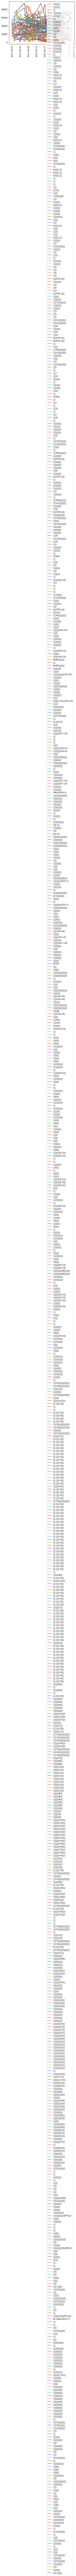

In [335]:
# plt.plot(APTTradeData['아파트']['보증금액'])
a = APTTradeData['보증금액'][APTTradeData['아파트'] == '아네스트염창']
b = APTTradeData['보증금액'][APTTradeData['아파트'] == '마곡푸르지오']

for i in APTTradeData['아파트']:
  plt.plot(APTTradeData['보증금액'][APTTradeData['아파트'] == i],label = i)
plt.xticks(rotation = 90)
plt.legend()
plt.show()

In [279]:
APTTradeData

,건축년도,년,법정동,보증금액,아파트,월,월세금액,일,전용면적,지번,지역코드,층,date
date,,,,,,,,,,,,,
2021-06-01,2019,2021,염창동,14500,아네스트염창,6,9,1,14.940,310,11500,7,2021-06-01
2021-06-01,2019,2021,염창동,17000,아네스트염창,6,12,1,14.940,310,11500,10,2021-06-01
2021-06-01,2000,2021,염창동,30450,극동,6,0,1,59.900,246-23,11500,3,2021-06-01
2021-06-01,1990,2021,염창동,37000,염창동한강우성,6,0,1,65.880,66-9,11500,1,2021-06-01
2021-06-01,2001,2021,염창동,55650,삼정그린코아,6,0,1,108.255,282,11500,9,2021-06-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-28,1994,2021,방화동,22000,방화12도시개발공사,6,0,28,51.030,852,11500,8,2021-06-28
2021-06-30,2007,2021,방화동,53000,마곡경남아너스빌,6,0,30,84.980,888,11500,7,2021-06-30
2021-06-30,1994,2021,방화동,15225,방화5,6,0,30,33.180,814,11500,5,2021-06-30
